# Image Stitching

### 2.1 Coding Questions

In [1]:
import cv2
import copy 
import numpy as np
from matplotlib import pyplot as plt

#### SIFT and Pyramid Image Blending 

In [2]:
"""Compute SIFT keypoints and corresponding descriptors for images 1Hill and 2Hill"""

# reading images to stitch
hill1 = cv2.imread('stitching_images/1Hill.JPG')  # query
hill2 = cv2.imread('stitching_images/2Hill.JPG')  # train
hill3 = cv2.imread('stitching_images/3Hill.JPG')

one_hill = cv2.cvtColor(hill1, cv2.COLOR_BGR2RGB)
two_hill = cv2.cvtColor(hill2, cv2.COLOR_BGR2RGB)
three_hill = cv2.cvtColor(hill3, cv2.COLOR_BGR2RGB)

# compute keypoints & descriptors 
sift_obj = cv2.xfeatures2d.SIFT_create()
keypoints_two, descriptors_two = sift_obj.detectAndCompute(two_hill, None)
keypoints_one, descriptors_one = sift_obj.detectAndCompute(one_hill, None)

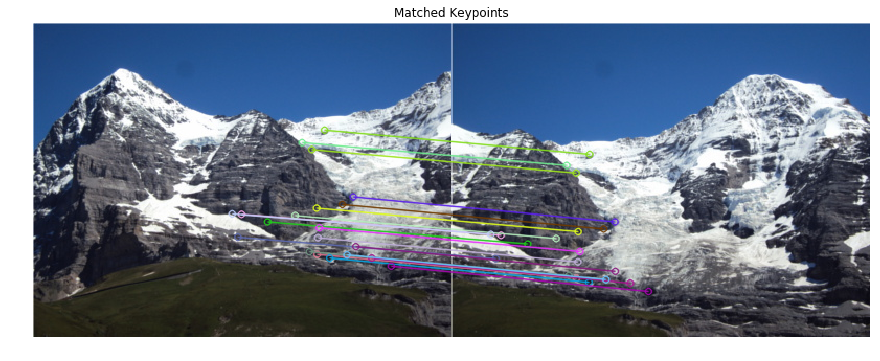

In [3]:
"""Find matching keypoints in two images and display the 20 best pairs"""

# match descriptors 
bf = cv2.BFMatcher()  # Brute-force descriptor matcher 
matches = bf.match(descriptors_one, descriptors_two)

# sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)  # sorted(mylist, key=WhatToSortBy)

# draw 20 best keypoints 
imgmatch = cv2.drawMatches(one_hill, keypoints_one, two_hill, keypoints_two, matches[:20], one_hill, flags=2)

# display results
plt.figure(figsize=(15,15))
plt.subplot(111), plt.imshow(imgmatch)
plt.title('Matched Keypoints'), plt.axis('off')
plt.show()

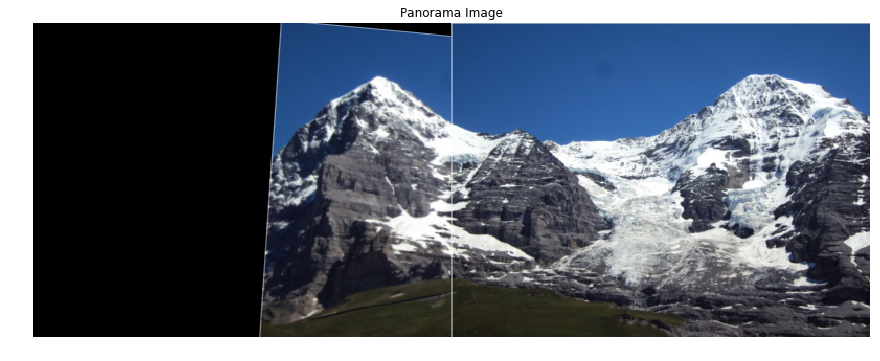

In [4]:
"""Find homography using RANSAC method and apply transformation to 1Hill"""

# arrange matching keypoints in separate lists 
GoodMatches = []
for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx)) 

mp_one = np.float32([keypoints_one[i].pt for (__, i) in GoodMatches])    
mp_two = np.float32([keypoints_two[i].pt for (i, __) in GoodMatches])    

# translation of keypoints in hill_two to the right 
for i in range(len(mp_two)):
    mp_two[i][0] += two_hill.shape[1]

# find homography and warp one_hill accordingly
H, __ = cv2.findHomography(mp_one, mp_two, cv2.RANSAC, 5) 
warp_one = cv2.warpPerspective(one_hill, H, (one_hill.shape[1]+two_hill.shape[1],one_hill.shape[0]))
warp_one_copy = copy.deepcopy(warp_one)

warp_one[:,two_hill.shape[1]:,:] = two_hill

# display results
plt.figure(figsize=(15,15))
plt.subplot(111), plt.imshow(warp_one)
plt.title('Panorama Image'), plt.axis('off')
plt.show()

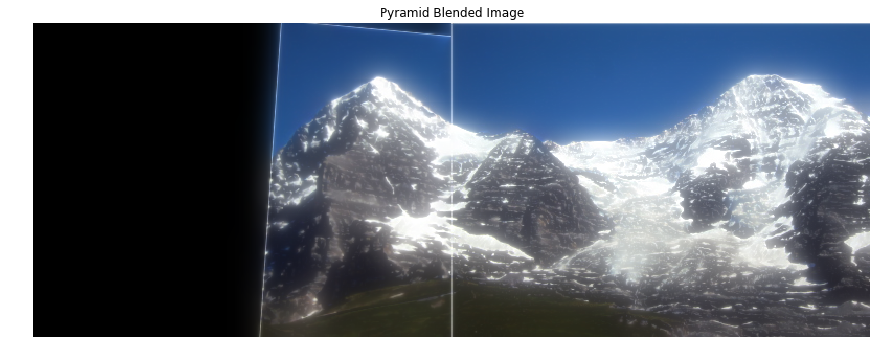

In [13]:
"""Stitch transformed 1Hill and original 2Hill together using pyramid image blending"""

# parameters
depth = 5 # pyramid depth size

# generate Gaussian pyramid for hill_two, warp_one_copy 
G_2, G_1 = two_hill.copy(), warp_one_copy.copy()
gp2, gp1 = [G_2], [G_1]

for i in range(depth):
    # downsample upper pyramid
    G_2 = cv2.pyrDown(G_2)
    G_1 =  cv2.pyrDown(G_1)
    gp2.append(G_2)
    gp1.append(G_1)
    
# generate Laplacian pyramid for hill_two, warp_one_copy
lp_2 = [gp2[depth-1]] # store last gaussian image for top of lp pyramid
lp_1 = [gp1[depth-1]] 

for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr_2 = cv2.pyrUp(gp2[i], dstsize=(gp2[i-1].shape[1], gp2[i-1].shape[0])) 
    lp = cv2.subtract(gp2[i-1], hr_2, cv2.CV_32F)  # subtract different levels
    lp_2.append(lp)

    hr_1 = cv2.pyrUp(gp1[i], dstsize=(gp1[i-1].shape[1], gp1[i-1].shape[0]))
    lp = cv2.subtract(gp1[i-1], hr_1, cv2.CV_32F)  # subtract different levels
    lp_1.append(lp)  
    
# add left and right halves of images in each level
LP = []
for la, lb in zip(lp_1, lp_2):
    row, cols, dpt = la.shape
    # stack columns (half and half)
    lp = np.hstack((la[:, :round(cols/2)], lb))
    LP.append(lp)
    
# now reconstruct
ls_ = LP[0]
for i in range(1,depth):
    h, w, _ = LP[i].shape
    ls_ = cv2.pyrUp(ls_, dstsize= (w, h))
    ls_ = cv2.add(ls_, LP[i])
    
twelve_hill = copy.deepcopy(ls_) # resultant image to be used in next section

# display results
plt.figure(figsize=(15,15))
plt.subplot(111), plt.imshow(ls_)
plt.title('Pyramid Blended Image'), plt.axis('off')
plt.show()

#### SURF and Linear Image Blending

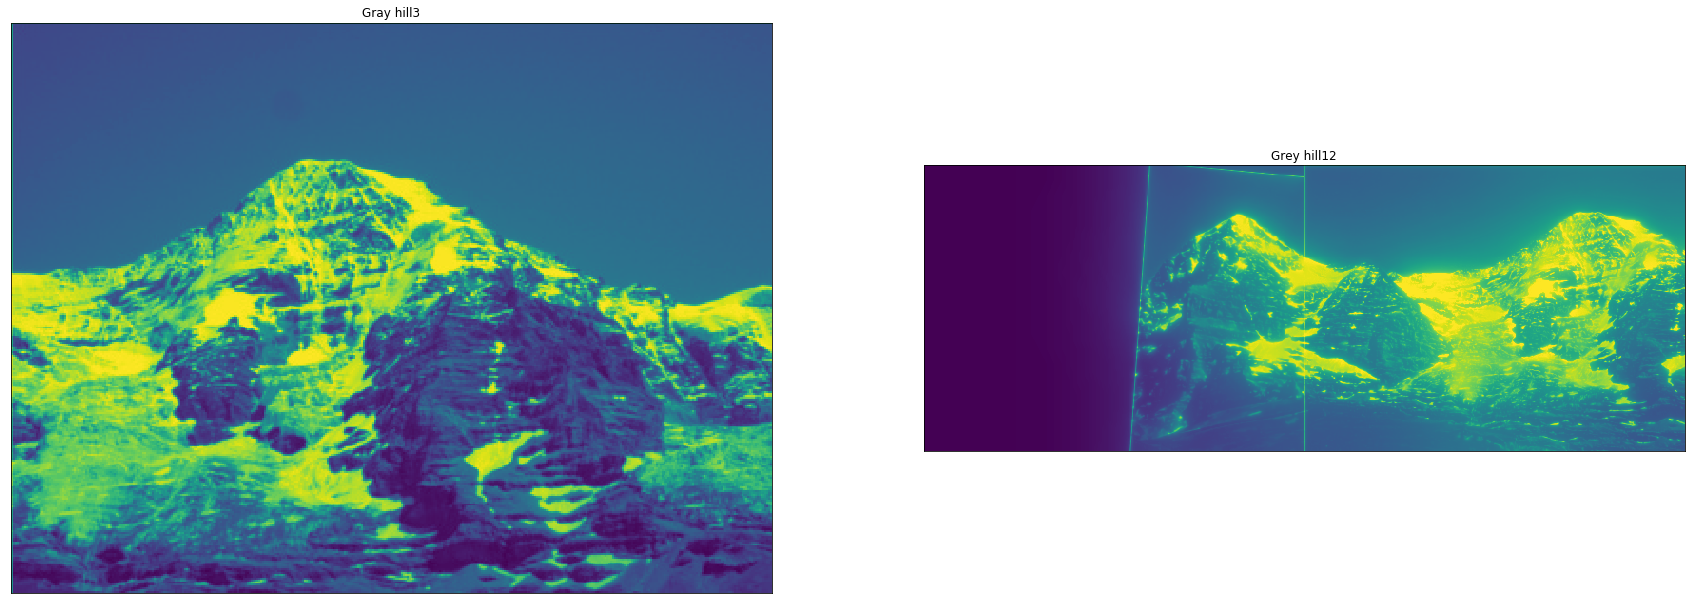

In [12]:
"""Compute SURF keypoints and corresponding descriptors for images 12Hill and 3Hill"""

# cvt. images to greyscale 
gray_hill3 = cv2.cvtColor(three_hill, cv2.COLOR_RGB2GRAY)
gray_hill12 = cv2.cvtColor(twelve_hill, cv2.COLOR_RGB2GRAY)

# compute keypoints & descriptors 
surf_obj = cv2.xfeatures2d.SURF_create()
keypoints_twelve, descriptors_twelve = surf_obj.detectAndCompute(gray_hill12, None)
keypoints_three, descriptors_three = surf_obj.detectAndCompute(gray_hill3, None)

#display images
plt.figure(figsize=(30,30))
plt.subplot(121), plt.imshow(gray_hill3)
plt.title("Gray hill3"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(gray_hill12)
plt.title("Grey hill12"), plt.xticks([]), plt.yticks([])
plt.show()

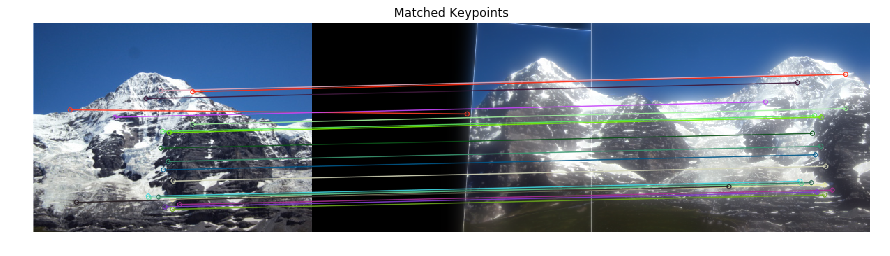

In [18]:
"""Find matching keypoints in two images and display the 20 best pairs"""

# match descriptors 
bf_2 = cv2.BFMatcher()  # Brute-force descriptor matcher 
matches_surf = bf_2.match(descriptors_three, descriptors_twelve)  # why does this need to be in a particular order!?

# sort them in the order of their distance.
matches_surf = sorted(matches_surf, key = lambda x:x.distance)  # sorted(mylist, key=WhatToSortBy)

# draw 20 best keypoints
imgmatch = cv2.drawMatches(three_hill, keypoints_three, twelve_hill, keypoints_twelve, matches_surf[:20], hill3, flags=10)

# display results
plt.figure(figsize=(15,15))
plt.subplot(111), plt.imshow(imgmatch)
plt.title('Matched Keypoints'), plt.axis('off')
plt.show()

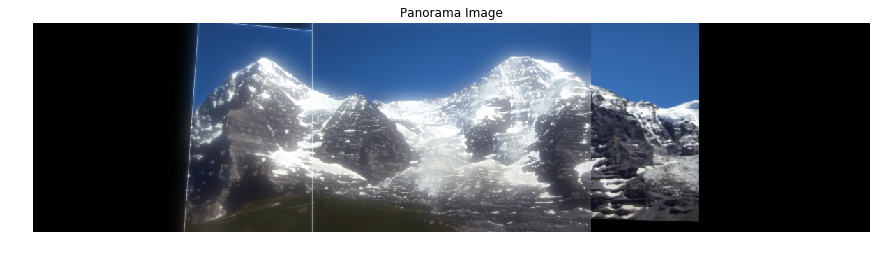

In [31]:
"""Find homography using RANSAC method and apply transformation to 3Hill"""

# arrange matching keypoints in separate lists 
GoodMatches = []
for i, m in enumerate(matches_surf):
    GoodMatches.append((m.trainIdx, m.queryIdx)) 

mp_three = np.float32([keypoints_three[i].pt for (__, i) in GoodMatches])    
mp_twelve = np.float32([keypoints_twelve[i].pt for (i, __) in GoodMatches])    

# translation of keypoints in hill_three to the right 
# for i in range(len(mp_three)):
#     mp_three[i][0] += twelve_hill.shape[1] + three_hill.shape[1]

# find homography and warp one_hill accordingly
H, __ = cv2.findHomography(mp_three, mp_twelve, cv2.RANSAC, 5) 
warp_one = cv2.warpPerspective(three_hill, H, (three_hill.shape[1]+twelve_hill.shape[1],three_hill.shape[0]))
warp_one_copy = copy.deepcopy(warp_one)

warp_one[:,:twelve_hill.shape[1],:] = twelve_hill
# display results
plt.figure(figsize=(15,15))
plt.subplot(111), plt.imshow(warp_one)
plt.title('Panorama Image'), plt.axis('off')
plt.show()

In [34]:
"""Stitch transformed 3Hill and 12Hill together and apply linear image blending"""


def Ramp(i_width, r_width, r_index, start, end):
    """
    Create alpha blending function
    :param i_width: img width
    :param r_width: ramp width
    :param r_index: center ramp index
    :param start: starting ramp value
    :param end: ending ramp value
    :return:
    """
    a = np.zeros((i_width))
    step = (end - start) / (r_width-1)
    idx = round(r_index - (r_width / 2))  # left side starting index of alpha ramp
    for i in range(r_width):
        a[idx] = start + step*i
        idx += 1
    a[idx:] = 1
    return a

### 2.2 Reasoning Questions

##### 1. What are the differences between SIFT and SURF? Comment on the speed, number of keypoints and density. Support your arguments with statistics.

TODO

##### 2. Discuss at least two pros and cons of pyramid and linear blending techniques. When should one prefer pyramid blending over linear blending?

TODO

##### 3. What would happen if a random subset of pairs of matching keypoints is used for finding homography?

TODO

##### 4. Discuss the relationship between the number of pairs of matching key-points used for finding homography and the accuracy of inferred homography.

TODO